# GeoIP mismatches

We want to inspect the reported IP address from measurements and compare it against the actual IP to see geolocalization mismatches

In [208]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from bokeh.plotting import figure, show

In [209]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [210]:
from clickhouse_driver import Client as Clickhouse
from uuid import uuid4
from pathlib import Path

def click_query(q, params=None):
    click = Clickhouse("localhost")
    return click.query_dataframe(q, params=params)

def click_query_fsn(q, params=None):
    click = Clickhouse("backend-fsn.ooni.org")
    return click.query_dataframe(q, params=params)

In [211]:
def get_explorer_url(e):
    return f'https://explorer.ooni.org/m/{e['measurement_uid']}'
def print_explorer_url(e):
    print(get_explorer_url(e))

In [212]:
!curl -O https://ooni-data-eu-fra.s3.eu-central-1.amazonaws.com/ip2country-as/20250301-ip2country_as.mmdb.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8287k  100 8287k    0     0  15.3M      0 --:--:-- --:--:-- --:--:-- 15.4M


In [213]:
import maxminddb
import geoip2.database
geoip_reader = geoip2.database.Reader('ip_db/dbip-full-2025-03.mmdb')
old_reader = geoip2.database.Reader('20250301-ip2country_as.mmdb')

In [214]:
def get_probe_cc(ip):
    try:
        return geoip_reader.get(ip)['country']['iso_code']
    except KeyError:
        return "ZZ"
def get_probe_asn(ip):
    try:
        asn = geoip_reader.get(ip)['autonomous_system_number']
    except KeyError:
        asn = 0
    return f"AS{asn}"

In [215]:
import re
import json
import pandas as pd
from io import StringIO

def print_log(s, log):
    if log:
        print(s)

def parse_tcpdump_file(file_path, log=False):
    # Read the file
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Split the content by packet boundaries (timestamps)
    packet_pattern = r'(\d+:\d+:\d+\.\d+ IP.*?)(?=\d+:\d+:\d+\.\d+ IP|\Z)'
    packets = re.findall(packet_pattern, content, re.DOTALL)
    
    # Initialize lists to store data
    data_list = []
    
    for packet in packets:
        packet_data = {}

        post_match = re.search(r'POST /api/v1/check-in', packet)
        if not post_match:
            print_log(f"does not match check-in {packet[:300]}", log)
            continue
        
        # Extract timestamp
        timestamp_match = re.search(r'(\d+:\d+:\d+\.\d+)', packet)
        if timestamp_match:
            packet_data['timestamp'] = timestamp_match.group(1)
        
        # Extract X-Real-IP header
        ip_match = re.search(r'X-Real-IP: (\S+)', packet, re.IGNORECASE)
        if ip_match:
            packet_data['X-Real-IP'] = ip_match.group(1)
        
        # Extract User-Agent header
        ua_match = re.search(r'user-agent: ([^\r\n]+)', packet, re.IGNORECASE)
        if ua_match:
            packet_data['User-Agent'] = ua_match.group(1)
        
        # Look for JSON payload after the HTTP headers
        # Find the end of headers (blank line) and then look for JSON
        parts = re.split(r'\r?\n\r?\n', packet, 1)
        if len(parts) > 1:
            body = parts[1].strip()
            # Check if the body starts with a curly brace (JSON)
            if body.startswith('{'):
                try:
                    json_data = json.loads(body)
                    # Add all JSON keys as columns
                    for key, value in json_data.items():
                        if isinstance(value, dict):
                            # Handle nested dictionaries
                            for sub_key, sub_value in value.items():
                                packet_data[f"{key}_{sub_key}"] = json.dumps(sub_value) if isinstance(sub_value, (dict, list)) else sub_value
                        else:
                            packet_data[key] = json.dumps(value) if isinstance(value, (dict, list)) else value
                except json.JSONDecodeError as e:
                    print_log(f"Could not parse JSON: {e}", log)
                    print_log(f"Body content: {body[:100]}...", log)
            else:
                print_log(f"Could not find JSON: {packet}", log)
        
        if packet_data:
            data_list.append(packet_data)
    
    # Create DataFrame
    df = pd.DataFrame(data_list)
    return df

In [216]:
df = parse_tcpdump_file('check-in-dump.txt', log=False)
df

,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes
0,15:22:48.791323,99.146.32.37,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS7018,US,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM..."
1,15:22:59.827622,130.43.131.140,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS42689,GB,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM..."
2,15:23:08.712985,76.78.140.223,ooniprobe-desktop-unattended/3.24.0 ooniprobe-...,True,True,windows,AS399325,US,timed,ooniprobe-desktop-unattended,3.24.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT..."
3,15:23:14.282669,190.142.248.200,ooniprobe-cli-unattended/3.22.0 ooniprobe-engi...,True,True,linux,AS21826,VE,timed,ooniprobe-cli-unattended,3.22.0,[]
4,15:23:19.704660,114.136.131.173,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,False,android,AS17421,TW,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16134,16:21:57.124658,68.110.27.68,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS22773,US,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT..."
16135,16:22:09.361568,78.27.86.223,ooniprobe-cli-unattended/3.23.0 ooniprobe-engi...,True,True,linux,AS16086,FI,timed,ooniprobe-cli-unattended,3.23.0,[]
16136,16:22:27.682182,109.133.25.35,ooniprobe-desktop-unattended/3.14.1 ooniprobe-...,True,True,windows,AS5432,BE,timed,ooniprobe-desktop-unattended,3.14.1,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT..."
16137,16:22:59.897889,46.208.198.48,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,True,android,AS6871,GB,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM..."


## Actual asn and country
Let's try to use the paid database to match the country and asn with the reported asn and country


In [236]:

result = geoip_reader.enterprise('99.146.32.37')
ip = '99.146.32.37'
from dataclasses import dataclass

@dataclass
class LookupResult:
    is_proxy : bool 
    asn: str
    asn_name:str
    country_code: str
    connection_type: str
    ip_user_type: str
    
def is_proxy(traits) -> bool:
    return traits.is_anonymous_proxy or traits.is_legitimate_proxy or traits.is_public_proxy or traits.is_residential_proxy 
    
def lookup(ip : str):
    enterprise_data = geoip_reader.enterprise(ip)
    traits = enterprise_data.traits

    is_proxy_ = is_proxy(traits)
    cc = enterprise_data.country.iso_code
    asn = traits.autonomous_system_number
    asn_name = traits.autonomous_system_organization
    connection_type = traits.connection_type
    ip_user_type = traits.user_type
    

    return LookupResult(is_proxy=is_proxy_, asn=asn, country_code=cc, connection_type=connection_type, asn_name = asn_name, ip_user_type = ip_user_type)
    
result.traits.connection_type

'Corporate'

## Create new DF with lookup data

In [234]:
lookup_df = df.copy()
lookup_df["is_proxy"] = False
lookup_df["lookup_cc"] = 'ZZ'
lookup_df['lookup_asn'] = 'ASXX'
lookup_df['lookup_asn_name'] = ""
lookup_df['connection_type'] = ""
lookup_df['ip_user_type'] = ''

In [238]:
for index, row in lookup_df.iterrows():
    result = lookup(row['X-Real-IP'])
    # WARNING: The isProxy field doesn't work, don't trust it
    lookup_df.at[index, 'is_proxy'] = result.is_proxy
    lookup_df.at[index, 'lookup_cc'] = result.country_code
    lookup_df.at[index, 'lookup_asn'] = f"AS{result.asn}"
    lookup_df.at[index, 'lookup_asn_name'] = result.asn_name
    lookup_df.at[index, 'ip_user_type'] = result.ip_user_type

    

lookup_df

,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
0,15:22:48.791323,99.146.32.37,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS7018,US,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,US,AS7018,"AT&T Services, Inc.",,business
1,15:22:59.827622,130.43.131.140,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS42689,GB,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,GB,AS42689,Glide Student & Residential Limited,,residential
2,15:23:08.712985,76.78.140.223,ooniprobe-desktop-unattended/3.24.0 ooniprobe-...,True,True,windows,AS399325,US,timed,ooniprobe-desktop-unattended,3.24.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,US,AS399325,Apogee Telecom Inc.,,business
3,15:23:14.282669,190.142.248.200,ooniprobe-cli-unattended/3.22.0 ooniprobe-engi...,True,True,linux,AS21826,VE,timed,ooniprobe-cli-unattended,3.22.0,[],False,VE,AS21826,Corporación Telemic C.A.,,business
4,15:23:19.704660,114.136.131.173,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,False,android,AS17421,TW,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,TW,AS17421,Mobile Business Group,,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16134,16:21:57.124658,68.110.27.68,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS22773,US,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,US,AS22773,Cox Communications Inc.,,business
16135,16:22:09.361568,78.27.86.223,ooniprobe-cli-unattended/3.23.0 ooniprobe-engi...,True,True,linux,AS16086,FI,timed,ooniprobe-cli-unattended,3.23.0,[],False,FI,AS16086,DNA Oyj,,business
16136,16:22:27.682182,109.133.25.35,ooniprobe-desktop-unattended/3.14.1 ooniprobe-...,True,True,windows,AS5432,BE,timed,ooniprobe-desktop-unattended,3.14.1,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,BE,AS5432,Proximus NV,,residential
16137,16:22:59.897889,46.208.198.48,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,True,android,AS6871,GB,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,GB,AS6871,British Telecommunications PLC,,residential


## Check which ones have mismatches between lookup CC and reported CC

In [240]:
bad_cc_df = lookup_df[lookup_df['probe_cc'] != lookup_df['lookup_cc']].reset_index()
bad_cc_df

,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
0,36,15:30:23.006716,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
1,38,15:30:30.213315,149.88.21.55,ooniprobe-desktop-unattended/3.9.2 ooniprobe-e...,True,True,macos,AS174,CA,timed,ooniprobe-desktop-unattended,3.9.2,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,US,AS212238,Datacamp Limited,,hosting
2,48,15:32:30.282950,185.230.125.194,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,True,android,AS56465,UA,autorun,ooniprobe-android-unattended,5.0.3,"[""GOVT"", ""HUMR"", ""IGO"", ""LGBT"", ""MMED"", ""NEWS""...",False,CH,AS9009,M247 Europe SRL,,hosting
3,53,15:32:49.506862,104.28.222.47,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,SG,AS13335,"Cloudflare, Inc.",,hosting
4,69,15:35:49.489840,76.9.201.198,ooniprobe-ios-unattended/5.0.3 ooniprobe-engin...,False,False,ios,AS21928,US,autorun,ooniprobe-ios-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,16030,16:02:01.466132,74.208.186.245,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS14593,CA,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,US,AS8560,IONOS SE,,hosting
843,16031,16:02:32.079289,185.121.232.216,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS0,ES,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,NL,AS216071,SERVERS TECH FZCO,,hosting
844,16066,16:09:00.602644,79.127.146.181,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,macos,AS9080,CZ,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,GB,AS212238,Datacamp Limited,,hosting
845,16078,16:11:07.002650,146.70.94.34,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS23969,TH,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,IE,AS9009,M247 Europe SRL,,hosting


There are some measurements with mismatch between lookup cc and reported cc

In [241]:
is_proxy_df = lookup_df[lookup_df['is_proxy']].reset_index()
is_proxy_df

,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type


It seems like there's no measurement with is proxy, wich is strage

In [242]:
bad_asn_df = lookup_df[lookup_df['probe_asn'] != lookup_df['lookup_asn']].reset_index()
bad_asn_df

,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
0,15,15:25:18.007479,97.228.67.235,ooniprobe-android/5.0.3 ooniprobe-engine/3.24.0,False,True,android,AS22394,US,ooni-run,ooniprobe-android,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,US,AS6167,Verizon Business,,cellular
1,38,15:30:30.213315,149.88.21.55,ooniprobe-desktop-unattended/3.9.2 ooniprobe-e...,True,True,macos,AS174,CA,timed,ooniprobe-desktop-unattended,3.9.2,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,US,AS212238,Datacamp Limited,,hosting
2,48,15:32:30.282950,185.230.125.194,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,False,True,android,AS56465,UA,autorun,ooniprobe-android-unattended,5.0.3,"[""GOVT"", ""HUMR"", ""IGO"", ""LGBT"", ""MMED"", ""NEWS""...",False,CH,AS9009,M247 Europe SRL,,hosting
3,55,15:33:12.932704,217.113.25.36,ooniprobe-desktop-unattended/3.14.1 ooniprobe-...,True,True,windows,AS49800,AM,timed,ooniprobe-desktop-unattended,3.14.1,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,AM,AS198265,I-NET LLC,,hosting
4,69,15:35:49.489840,76.9.201.198,ooniprobe-ios-unattended/5.0.3 ooniprobe-engin...,False,False,ios,AS21928,US,autorun,ooniprobe-ios-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,16030,16:02:01.466132,74.208.186.245,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS14593,CA,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,US,AS8560,IONOS SE,,hosting
937,16031,16:02:32.079289,185.121.232.216,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS0,ES,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,NL,AS216071,SERVERS TECH FZCO,,hosting
938,16066,16:09:00.602644,79.127.146.181,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,macos,AS9080,CZ,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,GB,AS212238,Datacamp Limited,,hosting
939,16078,16:11:07.002650,146.70.94.34,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS23969,TH,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,IE,AS9009,M247 Europe SRL,,hosting


The following table shows the results of each type of mismatch


In [243]:
n_samples = len(df)
n_bad_cc = len(bad_cc_df)
n_bad_asn = len(bad_asn_df)
n_errors = len(lookup_df[(lookup_df['probe_cc'] != lookup_df['lookup_cc']) | (lookup_df['probe_asn'] != lookup_df['lookup_asn'])])

total_df = pd.DataFrame({"Total samples" : [n_samples], "CC Mismatches" : [n_bad_cc], "ASN Mismatches" : [n_bad_asn], "Total Mismatches" : [n_errors], "Error rate" : [100 * n_errors/n_samples]})
total_df

,Total samples,CC Mismatches,ASN Mismatches,Total Mismatches,Error rate
0,16139,847,941,1196,7.41062


## Inspect CC errors

In [244]:
bad_cc_count_df = bad_cc_df.groupby(['probe_cc', 'lookup_cc']).size().reset_index(name="total").sort_values(by="total", ascending=False).reset_index()
bad_cc_count_df[:10]

,index,probe_cc,lookup_cc,total
0,183,US,CA,89
1,28,CA,RU,49
2,37,CZ,US,43
3,21,BS,US,36
4,33,CA,US,30
5,30,CA,SG,30
6,36,CZ,GB,25
7,25,CA,KH,18
8,7,AU,KH,18
9,186,US,DE,16


The most common type of mismatch is US to Canada, I suspect that it might have something to do with cloudflare

In [245]:
bad_cc_df[(bad_cc_df['probe_cc'] == 'US') & (bad_cc_df['lookup_cc'] == 'CA')]

,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
4,69,15:35:49.489840,76.9.201.198,ooniprobe-ios-unattended/5.0.3 ooniprobe-engin...,False,False,ios,AS21928,US,autorun,ooniprobe-ios-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
23,435,16:45:42.270555,38.99.128.251,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS30036,US,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS174,Cogent Communications,,cellular
68,1255,19:18:18.051207,38.99.128.251,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS30036,US,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS174,Cogent Communications,,cellular
81,1508,20:00:03.020781,76.9.201.203,ooniprobe-ios/5.0.5 ooniprobe-engine/3.24.0,False,True,ios,AS16591,US,ooni-run,ooniprobe-ios,5.0.5,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
84,1613,20:20:26.444557,172.105.103.170,ooniprobe-android/5.0.3 ooniprobe-engine/3.24.0,False,False,android,AS16904,US,ooni-run,ooniprobe-android,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS63949,"Akamai Technologies, Inc.",,hosting
86,1645,20:26:48.744124,76.9.201.204,ooniprobe-android/5.0.3 ooniprobe-engine/3.24.0,False,True,android,AS21928,US,ooni-run,ooniprobe-android,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
88,1677,20:32:34.266631,38.99.128.251,ooniprobe-android-unattended/5.0.3 ooniprobe-e...,True,True,android,AS30036,US,autorun,ooniprobe-android-unattended,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS174,Cogent Communications,,cellular
110,2063,21:46:23.926538,76.9.201.201,ooniprobe-ios/5.0.5 ooniprobe-engine/3.24.0,False,True,ios,AS10796,US,ooni-run,ooniprobe-ios,5.0.5,"[""PORN""]",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
111,2067,21:46:42.559110,76.9.201.201,ooniprobe-ios/5.0.5 ooniprobe-engine/3.24.0,False,True,ios,AS10796,US,ooni-run,ooniprobe-ios,5.0.5,"[""PORN""]",False,CA,AS21949,Beanfield Technologies Inc.,,cellular
117,2198,22:07:59.504445,148.113.163.33,ooniprobe-android/5.0.3 ooniprobe-engine/3.24.0,False,False,android,AS16904,US,ooni-run,ooniprobe-android,5.0.3,"[""ANON"", ""COMT"", ""CTRL"", ""CULTR"", ""ALDR"", ""COM...",False,CA,AS16276,OVH SAS,,hosting


It doesn't have anything to do with cloudflare! there are other asns

Looks like some asns repeat a lot, let's see how many of them we have

In [246]:
bad_cc_df[(bad_cc_df['probe_cc'] == 'US') & (bad_cc_df['lookup_cc'] == 'CA')].groupby(['lookup_asn', 'lookup_asn_name']).size().reset_index(name="total")

,lookup_asn,lookup_asn_name,total
0,AS16276,OVH SAS,2
1,AS174,Cogent Communications,34
2,AS21949,Beanfield Technologies Inc.,50
3,AS58065,Orion Network Limited,1
4,AS63949,"Akamai Technologies, Inc.",2


But how many ASNs do we have in canada? 

In [247]:
lookup_df[lookup_df['lookup_cc'] == "CA"].groupby(['lookup_asn', 'lookup_asn_name']).size().reset_index(name="total")

,lookup_asn,lookup_asn_name,total
0,AS11260,EastLink,14
1,AS1403,EBOX,3
2,AS16276,OVH SAS,10
3,AS174,Cogent Communications,56
4,AS19016,Westman Communications Group,1
5,AS20161,TeraGo Networks Inc.,1
6,AS212238,Datacamp Limited,3
7,AS21949,Beanfield Technologies Inc.,80
8,AS22423,Altima Telecom,14
9,AS22995,Xplore Inc.,10


Surprisingly, only 4 out of 28 ASNs are involved in these CC mismatches

## Inspect mismatches for Rusia and Canada
The second biggest mismatch source

In [248]:
bad_cc_df[(bad_cc_df['probe_cc'] == 'CA') & (bad_cc_df['lookup_cc'] == 'RU')].reset_index()

,level_0,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
0,0,36,15:30:23.006716,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
1,20,376,16:35:26.942045,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
2,39,711,17:34:06.583483,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
3,58,1014,18:33:19.007465,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
4,77,1467,19:54:19.427535,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
5,87,1666,20:30:22.594217,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
6,108,1972,21:30:23.230566,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
7,125,2401,22:48:11.007336,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
8,135,2648,23:30:22.422742,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
9,152,2981,00:34:16.050232,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting


All of these come from cloudflare!

In [249]:
bad_cc_df[(bad_cc_df['probe_cc'] == 'CA') & (bad_cc_df['lookup_cc'] == 'RU')].groupby(['lookup_asn','lookup_asn_name']).size().reset_index(name="total")

,lookup_asn,lookup_asn_name,total
0,AS13335,"Cloudflare, Inc.",49


In [250]:
bad_cc_df[(bad_cc_df['probe_cc'] == 'CA') & (bad_cc_df['lookup_cc'] == 'RU')]

,index,timestamp,X-Real-IP,User-Agent,charging,on_wifi,platform,probe_asn,probe_cc,run_type,software_name,software_version,web_connectivity_category_codes,is_proxy,lookup_cc,lookup_asn,lookup_asn_name,connection_type,ip_user_type
0,36,15:30:23.006716,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
20,376,16:35:26.942045,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
39,711,17:34:06.583483,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
58,1014,18:33:19.007465,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
77,1467,19:54:19.427535,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
87,1666,20:30:22.594217,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
108,1972,21:30:23.230566,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
125,2401,22:48:11.007336,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
135,2648,23:30:22.422742,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting
152,2981,00:34:16.050232,104.28.232.203,ooniprobe-desktop-unattended/3.23.0 ooniprobe-...,True,True,windows,AS13335,CA,timed,ooniprobe-desktop-unattended,3.23.0,"[""ALDR"", ""ANON"", ""COMM"", ""COMT"", ""CTRL"", ""CULT...",False,RU,AS13335,"Cloudflare, Inc.",,hosting


## ASN mismatches

In [251]:
bad_asn_df.groupby(['lookup_asn_name', 'lookup_asn', 'probe_asn', 'probe_cc', 'lookup_cc']).size().reset_index(name='total').sort_values(by='total', ascending=False)[:100].reset_index()[:10]

,index,lookup_asn_name,lookup_asn,probe_asn,probe_cc,lookup_cc,total
0,153,I-NET LLC,AS198265,AS49800,AM,AM,45
1,118,Datacamp Limited,AS212238,AS0,CZ,US,43
2,300,Proton AG,AS199218,AS198584,NL,NL,27
3,128,Datacamp Limited,AS212238,AS9080,CZ,GB,25
4,314,SkyNet Ltd.,AS35807,AS9123,RU,RU,19
5,131,"DigitalOcean, LLC",AS14061,AS21928,US,US,16
6,122,Datacamp Limited,AS212238,AS174,CA,US,15
7,141,FLEX NETWORK SARL,AS198545,AS174,FR,FR,15
8,73,Beanfield Technologies Inc.,AS21949,AS21928,US,CA,13
9,66,Beanfield Technologies Inc.,AS21949,AS16591,US,CA,13


# Corporate / Hosting connections
With the geoip database we can get the usage type of the connection for the IP, so we can use this as a sort-of proxy

In [254]:
bad_cc_types_df = bad_cc_df.groupby('ip_user_type').size().reset_index(name="total")
bad_cc_types_df

,ip_user_type,total
0,business,93
1,cellular,170
2,hosting,576
3,residential,8


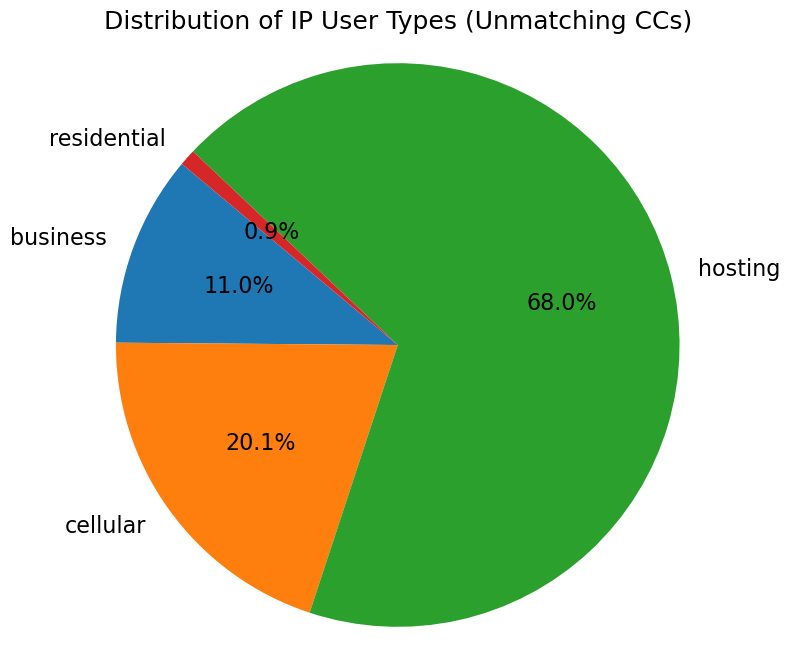

In [298]:
plt.figure(figsize=(8, 8))
plt.pie(bad_cc_types_df['total'], labels=bad_cc_types_df['ip_user_type'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 16} )
plt.title('Distribution of IP User Types (Unmatching CCs)', fontsize = 18)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.savefig("figures/ip_types_distribution_bad.png")
plt.show()

There seems to be a lot of measurements coming from hosting when they have problems, let's compare against the distribution of the ones that don't have problems

In [261]:
good_cc_df = lookup_df[lookup_df['probe_cc'] == lookup_df['lookup_cc']]
good_cc_types_df = good_cc_df.groupby('ip_user_type').size().reset_index(name='total')
good_cc_types_df

,ip_user_type,total
0,business,7208
1,cellular,2392
2,hosting,934
3,residential,4758


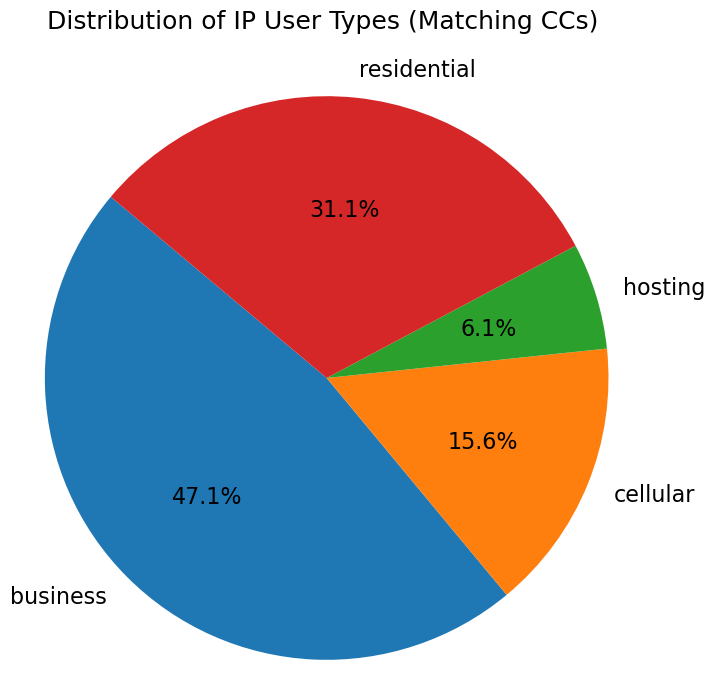

In [299]:
plt.figure(figsize=(8, 8))
plt.pie(good_cc_types_df['total'], labels=good_cc_types_df['ip_user_type'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 16})
plt.title('Distribution of IP User Types (Matching CCs) ', pad = 30, fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.savefig("figures/ip_types_distribution_good.png")
plt.show()

We know for sure that we have being a hosting connection has something to do with the bad measurements. 

Maybe we can check what hosting services are using the ones that fail and the ones that don't fail

In [279]:
bad_cc_hosting_df = bad_cc_df[bad_cc_df['ip_user_type'] == 'hosting']
good_cc_hosting_df = good_cc_df[good_cc_df['ip_user_type'] == 'hosting']

bad_cc_asn_total_df = bad_cc_hosting_df.groupby(['lookup_asn_name']).size().reset_index(name="total").sort_values('total', ascending=False)
bad_cc_asn_total_df[:10]

,lookup_asn_name,total
5,"Cloudflare, Inc.",179
19,M247 Europe SRL,118
7,Datacamp Limited,98
18,IONOS SE,45
3,AltusHost B.V.,30
22,PacketHub S.A.,22
2,"Akamai Technologies, Inc.",18
20,OVH SAS,15
26,SURF B.V.,8
24,SERVERS TECH FZCO,6


In [278]:
good_cc_asn_total_df = good_cc_hosting_df.groupby(['lookup_asn_name']).size().reset_index(name="total").sort_values('total', ascending=False)
good_cc_asn_total_df[:10]

,lookup_asn_name,total
19,Datacamp Limited,224
15,Clouvider Limited,101
46,M247 Europe SRL,50
5,"Alibaba (US) Technology Co., Ltd.",48
42,Iron Hosting Centre LTD,47
37,I-NET LLC,45
16,Cogent Communications,35
21,"DigitalOcean, LLC",34
48,NForce Entertainment B.V.,22
59,STARK INDUSTRIES SOLUTIONS LTD,22


Common providers for both cases:

In [285]:
good_providers = set(good_cc_asn_total_df[:10]["lookup_asn_name"])
bad_providers = set(bad_cc_asn_total_df[:10]["lookup_asn_name"])

good_providers.intersection(bad_providers)

{'Datacamp Limited', 'M247 Europe SRL'}

In [283]:
good_providers

{'Alibaba (US) Technology Co., Ltd.',
 'Clouvider Limited',
 'Cogent Communications',
 'Datacamp Limited',
 'DigitalOcean, LLC',
 'I-NET LLC',
 'Iron Hosting Centre LTD',
 'M247 Europe SRL',
 'NForce Entertainment B.V.',
 'STARK INDUSTRIES SOLUTIONS LTD'}

In general it seems like these connections always come from VPN providers

In [302]:
lookup_df[lookup_df['ip_user_type'] == 'hosting'].groupby('lookup_asn_name').size().reset_index(name='total').sort_values('total', ascending=False)[:10]

,lookup_asn_name,total
21,Datacamp Limited,322
16,"Cloudflare, Inc.",183
53,M247 Europe SRL,168
17,Clouvider Limited,102
45,IONOS SE,57
6,"Alibaba (US) Technology Co., Ltd.",48
49,Iron Hosting Centre LTD,47
44,I-NET LLC,45
24,"DigitalOcean, LLC",37
4,"Akamai Technologies, Inc.",36
